In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student, CustomResNet18
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss

In [21]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [30]:
# Hyperparameters
learning_rate = 0.04 # 0.096779
num_epochs = 200  # 200
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 10
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [31]:
# Load IdenProf dataset
train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

In [32]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

In [33]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)
student_model.fc = nn.Linear(student_model.output_size, 10)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# teacher_model.to(device)
# student_model.to(device)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.24it/s]


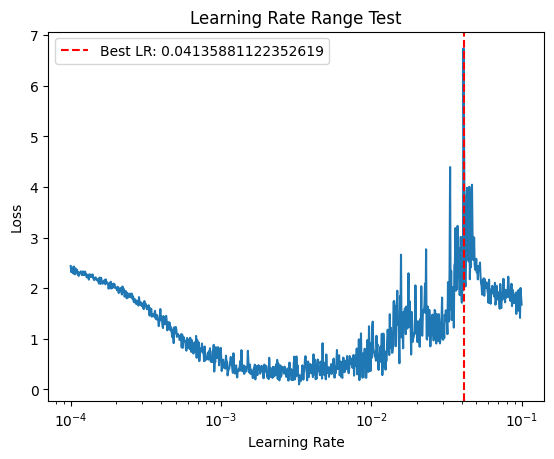

Best learning rate: 0.04135881122352619
0.04135881122352619


In [26]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

############# input ############## 
batch_size = 16  #to find the optimal learning rate
best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(best_lr)

In [34]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            # ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            # loss = alpha * kd_loss + (1 - alpha) * ce_loss

            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            loss = criterion(student_outputs, labels) + 0.1 * (distance_loss + angle_loss)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_rkd_prof_checkpoint.pth')
            torch.save(student, f'student_model_rkd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [35]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[1, 100] loss: 2.791


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[1, 200] loss: 1.948


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[2, 100] loss: 1.706


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[2, 200] loss: 1.608


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[3, 100] loss: 1.489


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[3, 200] loss: 1.387


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[4, 100] loss: 1.300


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[4, 200] loss: 1.284


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[5, 100] loss: 1.150


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[5, 200] loss: 1.202


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[6, 100] loss: 1.032


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[6, 200] loss: 1.038


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[7, 100] loss: 0.946


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[7, 200] loss: 0.960


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[8, 100] loss: 0.838


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[8, 200] loss: 0.877


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[9, 100] loss: 0.755


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[9, 200] loss: 0.769


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[10, 100] loss: 0.673


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[10, 200] loss: 0.752


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[11, 100] loss: 0.620


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[11, 200] loss: 0.615


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[12, 100] loss: 0.513


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[12, 200] loss: 0.530


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[13, 100] loss: 0.429


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[13, 200] loss: 0.454


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[14, 100] loss: 0.386


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[14, 200] loss: 0.367


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[15, 100] loss: 0.312


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.23it/s]

[15, 200] loss: 0.317


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[16, 100] loss: 0.241


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[16, 200] loss: 0.288


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.28it/s]

[17, 100] loss: 0.227


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[17, 200] loss: 0.227


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[18, 100] loss: 0.268


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[18, 200] loss: 0.202


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[19, 100] loss: 0.147


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[19, 200] loss: 0.166


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[20, 100] loss: 0.141


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.24it/s]

[20, 200] loss: 0.121


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[21, 100] loss: 0.102


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.24it/s]

[21, 200] loss: 0.129


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[22, 100] loss: 0.144


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[22, 200] loss: 0.112


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[23, 100] loss: 0.076


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[23, 200] loss: 0.098


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[24, 100] loss: 0.096


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[24, 200] loss: 0.090


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[25, 100] loss: 0.077


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[25, 200] loss: 0.099


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[26, 100] loss: 0.084


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[26, 200] loss: 0.063


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[27, 100] loss: 0.044


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[27, 200] loss: 0.053


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[28, 100] loss: 0.029


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.27it/s]

[28, 200] loss: 0.051


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[29, 100] loss: 0.079


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[29, 200] loss: 0.047


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[30, 100] loss: 0.083


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[30, 200] loss: 0.045


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[31, 100] loss: 0.019


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[31, 200] loss: 0.009


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[32, 100] loss: 0.010


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[32, 200] loss: 0.006


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[33, 100] loss: 0.007


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[33, 200] loss: 0.007


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[34, 100] loss: 0.005


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[34, 200] loss: 0.004


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:22,  8.22it/s]

[35, 100] loss: 0.005


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.24it/s]

[35, 200] loss: 0.004


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.27it/s]

[36, 100] loss: 0.003


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[36, 200] loss: 0.007


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[37, 100] loss: 0.003


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[37, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[38, 100] loss: 0.003


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[38, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[39, 100] loss: 0.004


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[39, 200] loss: 0.005


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[40, 100] loss: 0.004


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[40, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[41, 100] loss: 0.005


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[41, 200] loss: 0.004


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[42, 100] loss: 0.003


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.24it/s]

[42, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[43, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[43, 200] loss: 0.001


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[44, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[44, 200] loss: 0.004


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[45, 100] loss: 0.004


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[45, 200] loss: 0.001


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[46, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[46, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[47, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[47, 200] loss: 0.001


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[48, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.26it/s]

[48, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.24it/s]

[49, 100] loss: 0.001


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[49, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.24it/s]

[50, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[50, 200] loss: 0.001


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.25it/s]

[51, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[51, 200] loss: 0.002


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:12<00:21,  8.26it/s]

[52, 100] loss: 0.002


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:24<00:09,  8.25it/s]

[52, 200] loss: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.23it/s]


Early stopping
Finished Training Teacher


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.88it/s]

[1, 100] loss: 5.803


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[1, 200] loss: 4.775


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.88it/s]

[2, 100] loss: 4.060


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[2, 200] loss: 3.807


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[3, 100] loss: 3.619


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[3, 200] loss: 3.435


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[4, 100] loss: 3.252


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[4, 200] loss: 3.241


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[5, 100] loss: 3.048


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[5, 200] loss: 2.956


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.88it/s]

[6, 100] loss: 2.896


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[6, 200] loss: 2.697


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[7, 100] loss: 2.704


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[7, 200] loss: 2.603


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[8, 100] loss: 2.362


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[8, 200] loss: 2.436


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[9, 100] loss: 2.192


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.88it/s]

[9, 200] loss: 2.122


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[10, 100] loss: 2.097


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.86it/s]

[10, 200] loss: 2.077


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.87it/s]

[11, 100] loss: 1.792


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.88it/s]

[11, 200] loss: 1.854


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[12, 100] loss: 1.667


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[12, 200] loss: 1.660


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[13, 100] loss: 1.550


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[13, 200] loss: 1.469


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.88it/s]

[14, 100] loss: 1.421


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.83it/s]

[14, 200] loss: 1.363


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[15, 100] loss: 1.268


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[15, 200] loss: 1.212


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[16, 100] loss: 1.161


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[16, 200] loss: 1.126


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[17, 100] loss: 1.060


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[17, 200] loss: 1.051


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[18, 100] loss: 0.995


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[18, 200] loss: 1.015


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[19, 100] loss: 1.571


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.93it/s]

[19, 200] loss: 1.348


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[20, 100] loss: 1.053


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[20, 200] loss: 1.025


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.93it/s]

[21, 100] loss: 0.966


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.94it/s]

[21, 200] loss: 0.951


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[22, 100] loss: 0.898


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[22, 200] loss: 0.897


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[23, 100] loss: 0.864


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[23, 200] loss: 0.870


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[24, 100] loss: 0.828


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[24, 200] loss: 0.833


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.86it/s]

[25, 100] loss: 0.816


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.85it/s]

[25, 200] loss: 0.825


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[26, 100] loss: 0.793


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[26, 200] loss: 0.792


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[27, 100] loss: 0.779


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[27, 200] loss: 0.785


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[28, 100] loss: 0.751


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[28, 200] loss: 0.772


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[29, 100] loss: 0.759


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[29, 200] loss: 0.732


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[30, 100] loss: 0.748


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[30, 200] loss: 0.739


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[31, 100] loss: 0.780


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[31, 200] loss: 0.749


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[32, 100] loss: 0.702


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.88it/s]

[32, 200] loss: 0.702


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[33, 100] loss: 0.683


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[33, 200] loss: 0.691


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[34, 100] loss: 0.681


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[34, 200] loss: 0.666


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[35, 100] loss: 0.658


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[35, 200] loss: 0.661


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[36, 100] loss: 0.650


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[36, 200] loss: 0.656


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:13, 12.93it/s]

[37, 100] loss: 0.643


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.93it/s]

[37, 200] loss: 0.651


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[38, 100] loss: 0.649


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[38, 200] loss: 0.638


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[39, 100] loss: 0.627


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[39, 200] loss: 0.634


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[40, 100] loss: 0.628


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[40, 200] loss: 0.630


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.93it/s]

[41, 100] loss: 0.623


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[41, 200] loss: 0.630


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[42, 100] loss: 0.620


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[42, 200] loss: 0.629


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[43, 100] loss: 0.625


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[43, 200] loss: 0.617


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:08<00:14, 12.86it/s]

[44, 100] loss: 0.608


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[44, 200] loss: 0.596


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[45, 100] loss: 0.603


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[45, 200] loss: 0.605


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[46, 100] loss: 0.608


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[46, 200] loss: 0.606


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:08<00:14, 12.86it/s]

[47, 100] loss: 0.584


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.86it/s]

[47, 200] loss: 0.602


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[48, 100] loss: 0.608


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[48, 200] loss: 0.592


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[49, 100] loss: 0.598


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.88it/s]

[49, 200] loss: 0.605


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[50, 100] loss: 0.608


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[50, 200] loss: 0.585


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[51, 100] loss: 0.595


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[51, 200] loss: 0.591


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[52, 100] loss: 0.586


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[52, 200] loss: 0.599


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[53, 100] loss: 0.586


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[53, 200] loss: 0.592


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[54, 100] loss: 0.584


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[54, 200] loss: 0.583


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[55, 100] loss: 0.581


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[55, 200] loss: 0.577


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[56, 100] loss: 0.578


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[56, 200] loss: 0.568


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.91it/s]

[57, 100] loss: 0.574


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[57, 200] loss: 0.583


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[58, 100] loss: 0.569


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[58, 200] loss: 0.575


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.88it/s]

[59, 100] loss: 0.567


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[59, 200] loss: 0.566


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[60, 100] loss: 0.568


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[60, 200] loss: 0.577


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[61, 100] loss: 0.571


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[61, 200] loss: 0.565


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[62, 100] loss: 0.563


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[62, 200] loss: 0.561


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.86it/s]

[63, 100] loss: 0.565


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[63, 200] loss: 0.555


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.93it/s]

[64, 100] loss: 0.563


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.92it/s]

[64, 200] loss: 0.553


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:08<00:14, 12.88it/s]

[65, 100] loss: 0.560


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[65, 200] loss: 0.556


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.88it/s]

[66, 100] loss: 0.562


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.87it/s]

[66, 200] loss: 0.550


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.89it/s]

[67, 100] loss: 0.562


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.91it/s]

[67, 200] loss: 0.552


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[68, 100] loss: 0.546


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[68, 200] loss: 0.556


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[69, 100] loss: 0.552


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.89it/s]

[69, 200] loss: 0.559


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.90it/s]

[70, 100] loss: 0.561


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[70, 200] loss: 0.559


 36%|███████████████████████████████████████▊                                                                       | 101/282 [00:07<00:14, 12.92it/s]

[71, 100] loss: 0.559


 71%|███████████████████████████████████████████████████████████████████████████████                                | 201/282 [00:15<00:06, 12.90it/s]

[71, 200] loss: 0.555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:21<00:00, 12.85it/s]

Early stopping
Finished Training Student


In [36]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_rkd_prof.pth')
torch.save(student_model, 'student_model_rkd_prof.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_prof.pth')
torch.save(teacher_model, 'teacher_model_rkd_prof.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [15]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

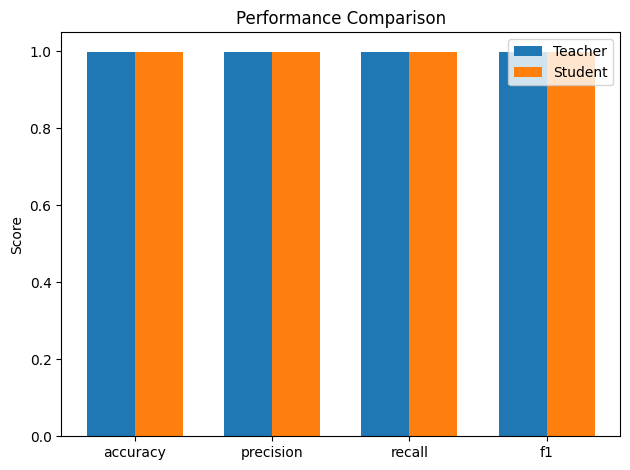

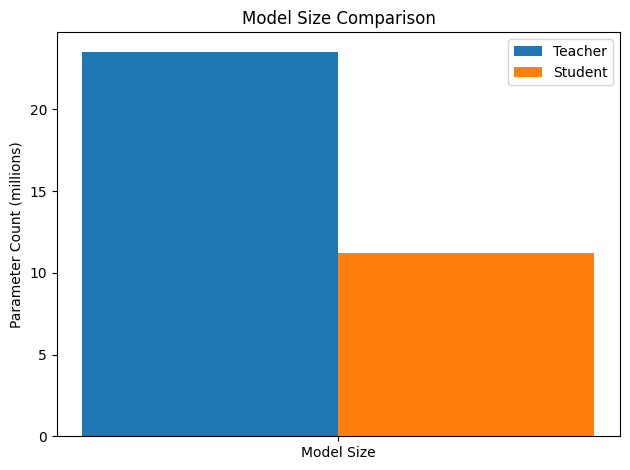

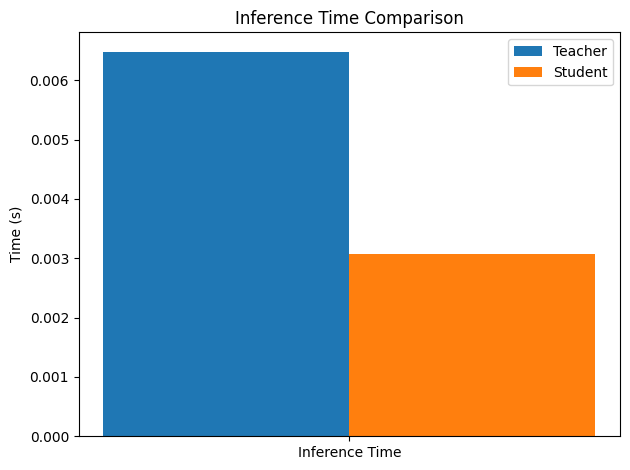

In [37]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

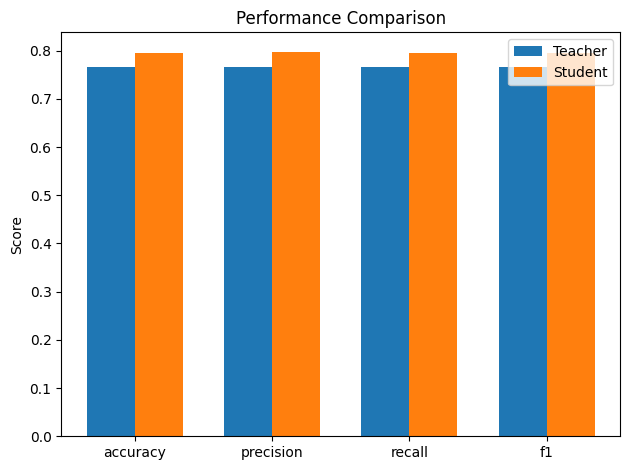

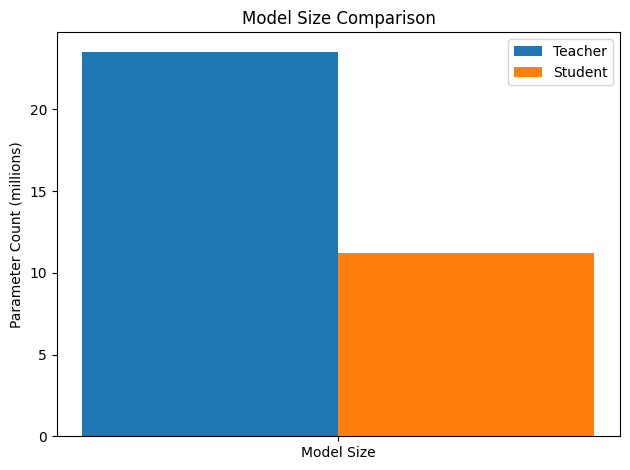

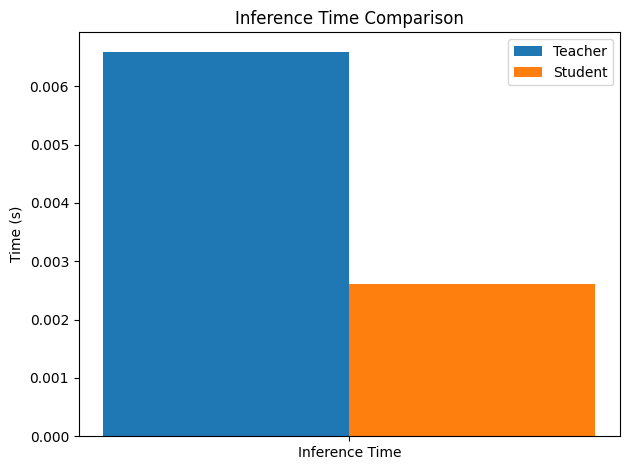

In [38]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')